# 1. Loading the data

### We are going to analyze single-cell RNA-seq data that are available at the GEO database : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE121521
### Sample is here : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3438654
### Publication is here : https://www.nature.com/articles/s41564-019-0633-0

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.6


In [3]:
results_file = 'write/resultfile'

In [4]:
adata = sc.read_10x_mtx('GSM3438654', var_names='gene_symbols', cache=True)

... reading from cache file cache\GSM3438654-matrix.h5ad


## Preprocessing

### Basic filtering

In [5]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

filtered out 14371 genes that are detected in less than 10 cells


In [6]:
adata

AnnData object with n_obs × n_vars = 9296 × 13627
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

### Genes

In [7]:
adata.var

gene_ids  n_cells
Rp1             ENSMUSG00000025900      287
Mrpl15          ENSMUSG00000033845     2587
Lypla1          ENSMUSG00000025903     2209
Tcea1           ENSMUSG00000033813     3817
Atp6v1h         ENSMUSG00000033793     1341
...                            ...      ...
AC168977.2      ENSMUSG00000094915       41
AC168977.1      ENSMUSG00000079808      229
PISD            ENSMUSG00000095041     5478
DHRSX           ENSMUSG00000063897     2085
CAAA01147332.1  ENSMUSG00000095742      133

[13627 rows x 2 columns]

In [8]:
adata.var_names

Index(['Rp1', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1',
       '4732440D04Rik', 'Pcmtd1', 'Gm26901', 'Rrs1',
       ...
       'AC133103.1', 'AC132444.1', 'Csprs', 'AC125149.3', 'AC125149.2',
       'AC168977.2', 'AC168977.1', 'PISD', 'DHRSX', 'CAAA01147332.1'],
      dtype='object', length=13627)

## Observations

In [9]:
adata.obs.head(10)

n_genes
AAACCTGAGAAGGTGA-1     1826
AAACCTGAGATCGATA-1     1742
AAACCTGAGCTGCGAA-1      979
AAACCTGAGTGTGGCA-1     2370
AAACCTGCAGGGTATG-1     2191
AAACCTGCATGCCTAA-1     2892
AAACCTGCATGGTCAT-1     1585
AAACCTGCATTACCTT-1     2262
AAACCTGCATTCGACA-1     2350
AAACCTGGTCCAGTGC-1     1592

## Unstructured data

It will be empty for now

In [10]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict()
With overloaded keys:
	['neighbors'].

## Matrix

In [11]:
adata.X

<9296x13627 sparse matrix of type '<class 'numpy.float32'>'
	with 18268821 stored elements in Compressed Sparse Row format>

### Show those genes that yield the highest fraction of counts in each single cell, across all cells

normalizing counts per cell
    finished (0:00:00)


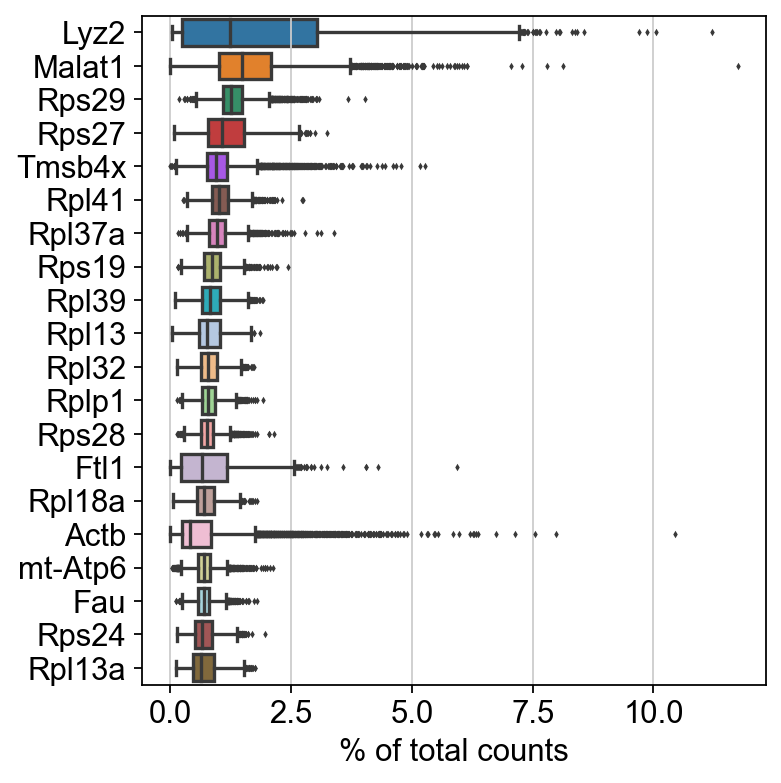

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 2. Visualize and filter out poor-quality cells

In single cell analysis, mitochondrial DNA is highly detected in dying cells. We want to remove those bad quality cells.

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var

gene_ids  n_cells     mt
Rp1             ENSMUSG00000025900      287  False
Mrpl15          ENSMUSG00000033845     2587  False
Lypla1          ENSMUSG00000025903     2209  False
Tcea1           ENSMUSG00000033813     3817  False
Atp6v1h         ENSMUSG00000033793     1341  False
...                            ...      ...    ...
AC168977.2      ENSMUSG00000094915       41  False
AC168977.1      ENSMUSG00000079808      229  False
PISD            ENSMUSG00000095041     5478  False
DHRSX           ENSMUSG00000063897     2085  False
CAAA01147332.1  ENSMUSG00000095742      133  False

[13627 rows x 3 columns]

In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [15]:
adata.obs

n_genes  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGAAGGTGA-1     1826               1825                 7.509883   
AAACCTGAGATCGATA-1     1742               1741                 7.462789   
AAACCTGAGCTGCGAA-1      979                979                 6.887553   
AAACCTGAGTGTGGCA-1     2370               2370                 7.771067   
AAACCTGCAGGGTATG-1     2191               2190                 7.692113   
...                     ...                ...                      ...   
TTTGTCATCATTGCCC-1     2543               2542                 7.841100   
TTTGTCATCCATGAGT-1     3320               3317                 8.107117   
TTTGTCATCCCATTAT-1     1061               1060                 6.966967   
TTTGTCATCCCATTTA-1     1085               1085                 6.990257   
TTTGTCATCTTTAGGG-1     1689               1689                 7.432484   

                    total_counts  log1p_total_counts  total_counts_mt  \
AAACCTGAGAAGGTGA-1        6109.0            8.717682            243.0   
AAACCTGAGATCGATA-1        6796.0            8.824237            267.0   
AAACCTGAGCTGCGAA-1        3589.0            8.185907             90.0   
AAACCTGAGTGTGGCA-1       10196.0            9.229849            290.0   
AAACCTGCAGGGTATG-1        8396.0            9.035630            281.0   
...                          ...                 ...              ...   
TTTGTCATCATTGCCC-1       10464.0            9.255792            387.0   
TTTGTCATCCATGAGT-1       14962.0            9.613336            432.0   
TTTGTCATCCCATTAT-1        2682.0            7.894691             57.0   
TTTGTCATCCCATTTA-1        2658.0            7.885705            111.0   
TTTGTCATCTTTAGGG-1        6058.0            8.709300            160.0   

                    log1p_total_counts_mt  pct_counts_mt  
AAACCTGAGAAGGTGA-1               5.497168       3.977738  
AAACCTGAGATCGATA-1               5.590987       3.928782  
AAACCTGAGCTGCGAA-1               4.510859       2.507662  
AAACCTGAGTGTGGCA-1               5.673323       2.844253  
AAACCTGCAGGGTATG-1               5.641907       3.346832  
...                                   ...            ...  
TTTGTCATCATTGCCC-1               5.961005       3.698395  
TTTGTCATCCATGAGT-1               6.070738       2.887315  
TTTGTCATCCCATTAT-1               4.060443       2.125280  
TTTGTCATCCCATTTA-1               4.718499       4.176073  
TTTGTCATCTTTAGGG-1               5.081404       2.641136  

[9296 rows x 8 columns]

In [16]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
Rp1             ENSMUSG00000025900      287  False                287   
Mrpl15          ENSMUSG00000033845     2587  False               2587   
Lypla1          ENSMUSG00000025903     2209  False               2209   
Tcea1           ENSMUSG00000033813     3817  False               3817   
Atp6v1h         ENSMUSG00000033793     1341  False               1341   
...                            ...      ...    ...                ...   
AC168977.2      ENSMUSG00000094915       41  False                 41   
AC168977.1      ENSMUSG00000079808      229  False                229   
PISD            ENSMUSG00000095041     5478  False               5478   
DHRSX           ENSMUSG00000063897     2085  False               2085   
CAAA01147332.1  ENSMUSG00000095742      133  False                133   

                mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
Rp1                0.033240           0.032700              96.912651   
Mrpl15             0.351441           0.301172              72.170826   
Lypla1             0.283563           0.249640              76.237091   
Tcea1              0.574763           0.454105              58.939329   
Atp6v1h            0.162651           0.150702              85.574441   
...                     ...                ...                    ...   
AC168977.2         0.004518           0.004508              99.558950   
AC168977.1         0.029260           0.028840              97.536575   
PISD               1.163404           0.771683              41.071429   
DHRSX              0.268287           0.237668              77.570998   
CAAA01147332.1     0.014522           0.014418              98.569277   

                total_counts  log1p_total_counts  
Rp1                    309.0            5.736572  
Mrpl15                3267.0            8.091933  
Lypla1                2636.0            7.877397  
Tcea1                 5343.0            8.583730  
Atp6v1h               1512.0            7.321850  
...                      ...                 ...  
AC168977.2              42.0            3.761200  
AC168977.1             272.0            5.609472  
PISD                 10815.0            9.288782  
DHRSX                 2494.0            7.822044  
CAAA01147332.1         135.0            4.912655  

[13627 rows x 9 columns]

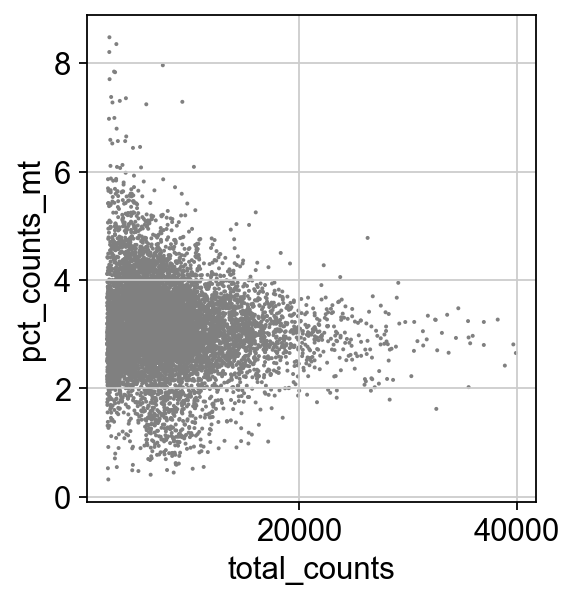

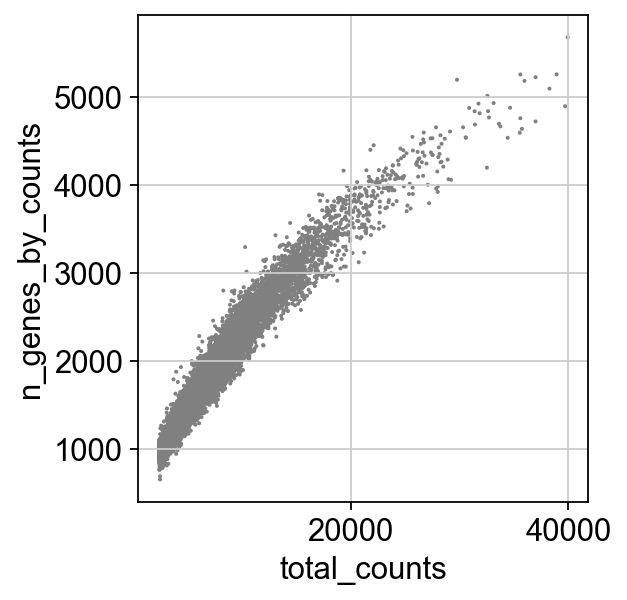

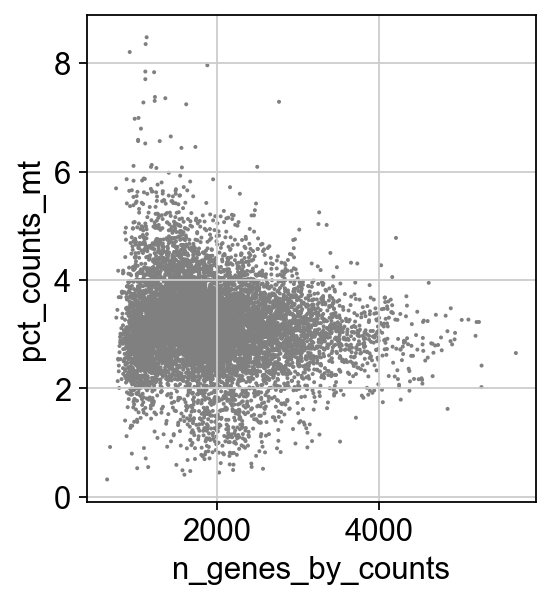

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

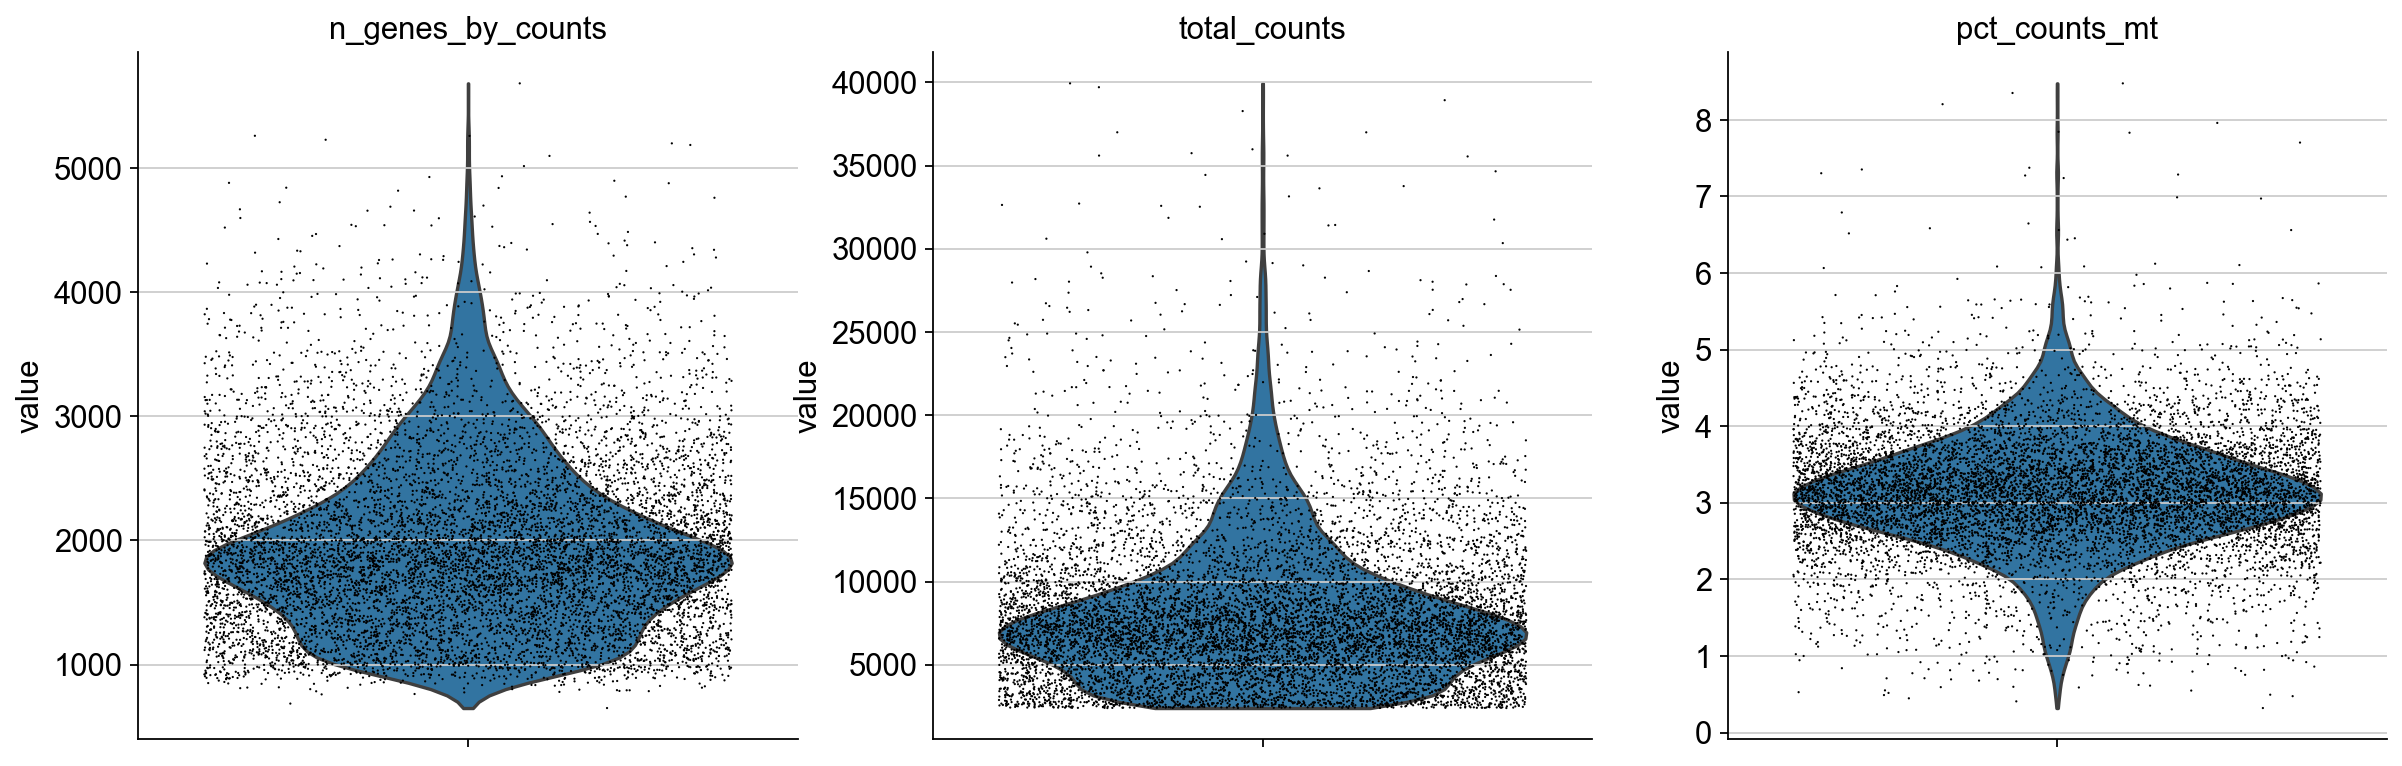

In [18]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [19]:
adata = adata[adata.obs.n_genes_by_counts > 900, :].copy()
adata = adata[adata.obs.pct_counts_mt < 4.5, :].copy()

adata

AnnData object with n_obs × n_vars = 8800 × 13627
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

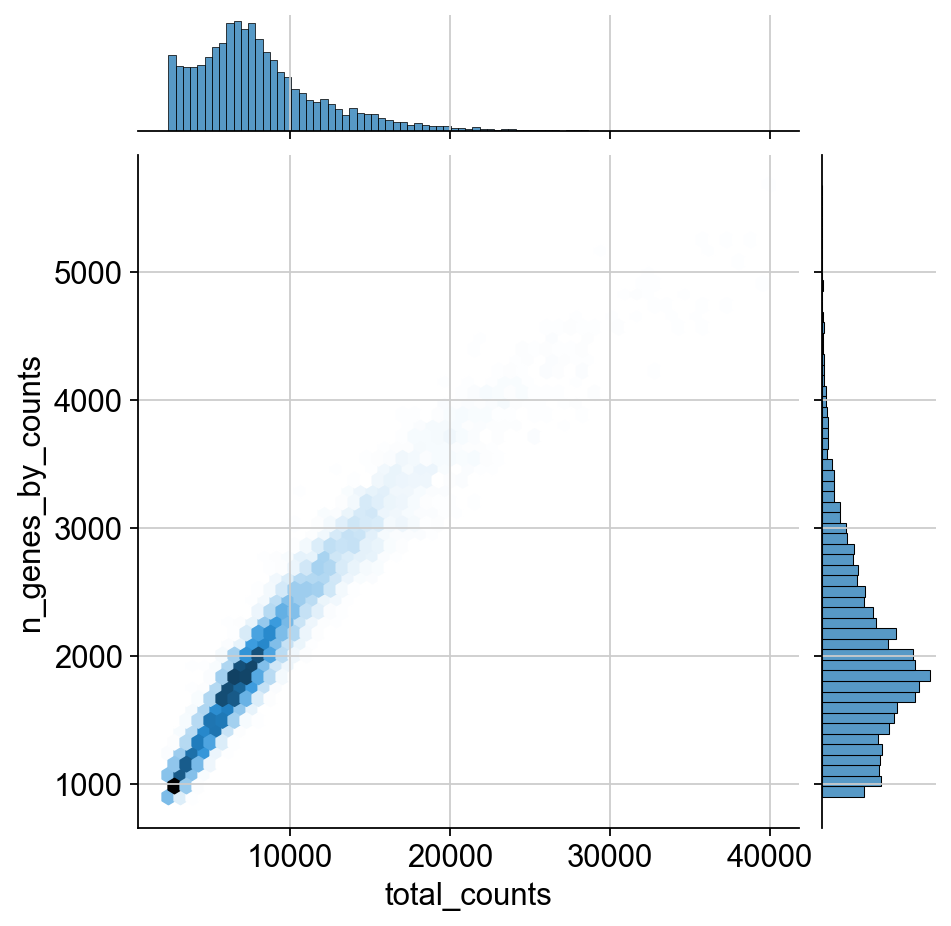

In [20]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

# 3. Normalize and scale the data

In [21]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

0    1    2    3    4    5    6    7    8    9   ...   90   91   92   93  \
0   1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  2.0  0.0  0.0   
1   0.0  1.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  1.0  ...  2.0  2.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  2.0  0.0  0.0   
96  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  1.0  0.0  0.0   
98  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
99  0.0  0.0  1.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   

     94   95   96    97   98   99  
0   1.0  0.0  1.0  20.0  0.0  0.0  
1   1.0  0.0  0.0  29.0  0.0  0.0  
2   0.0  0.0  0.0  16.0  0.0  0.0  
3   0.0  0.0  0.0  26.0  0.0  0.0  
4   0.0  0.0  1.0  37.0  0.0  0.0  
..  ...  ...  ...   ...  ...  ...  
95  1.0  0.0  0.0  15.0  0.0  0.0  
96  0.0  0.0  0.0   7.0  0.0  0.0  
97  0.0  0.0  1.0  28.0  0.0  0.0  
98  0.0  0.0  0.0  29.0  0.0  1.0  
99  0.0  1.0  0.0  14.0  0.0  0.0  

[100 rows x 100 columns]

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [23]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

0         1         2         3         4    5    6         7    8   \
0   0.969615  0.000000  0.000000  0.969615  0.000000  0.0  0.0  0.969615  0.0   
1   0.000000  0.904807  0.000000  0.000000  0.000000  0.0  0.0  1.929464  0.0   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0   
3   0.000000  0.683489  0.000000  0.000000  0.000000  0.0  0.0  0.683489  0.0   
4   0.000000  0.784378  0.784378  0.000000  0.000000  0.0  0.0  0.784378  0.0   
..       ...       ...       ...       ...       ...  ...  ...       ...  ...   
95  0.000000  0.000000  0.669236  0.000000  0.669236  0.0  0.0  0.000000  0.0   
96  0.000000  0.000000  1.293302  0.000000  0.000000  0.0  0.0  0.000000  0.0   
97  0.000000  0.000000  0.000000  0.000000  0.700221  0.0  0.0  0.700221  0.0   
98  0.626273  0.626273  0.000000  0.626273  0.626273  0.0  0.0  0.626273  0.0   
99  0.000000  0.000000  1.097015  0.000000  0.000000  0.0  0.0  1.607521  0.0   

          9   ...        90        91        92   93        94        95  \
0   0.000000  ...  0.000000  1.452517  0.000000  0.0  0.969615  0.000000   
1   0.904807  ...  1.371918  1.371918  0.000000  0.0  0.904807  0.000000   
2   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
3   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
4   0.000000  ...  0.000000  0.000000  0.784378  0.0  0.000000  0.000000   
..       ...  ...       ...       ...       ...  ...       ...       ...   
95  0.000000  ...  0.669236  1.066601  0.000000  0.0  0.669236  0.000000   
96  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
97  0.000000  ...  0.700221  0.700221  0.000000  0.0  0.000000  0.000000   
98  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
99  0.000000  ...  0.000000  0.000000  1.097015  0.0  0.000000  1.097015   

          96        97   98        99  
0   0.969615  3.518642  0.0  0.000000  
1   0.000000  3.776711  0.0  0.000000  
2   0.000000  3.819484  0.0  0.000000  
3   0.000000  3.277152  0.0  0.000000  
4   0.784378  3.808186  0.0  0.000000  
..       ...       ...  ...       ...  
95  0.000000  2.727275  0.0  0.000000  
96  0.000000  2.971113  0.0  0.000000  
97  0.700221  3.380912  0.0  0.000000  
98  0.000000  3.267595  0.0  0.626273  
99  0.000000  3.364981  0.0  0.000000  

[100 rows x 100 columns]

normalizing counts per cell
    finished (0:00:00)


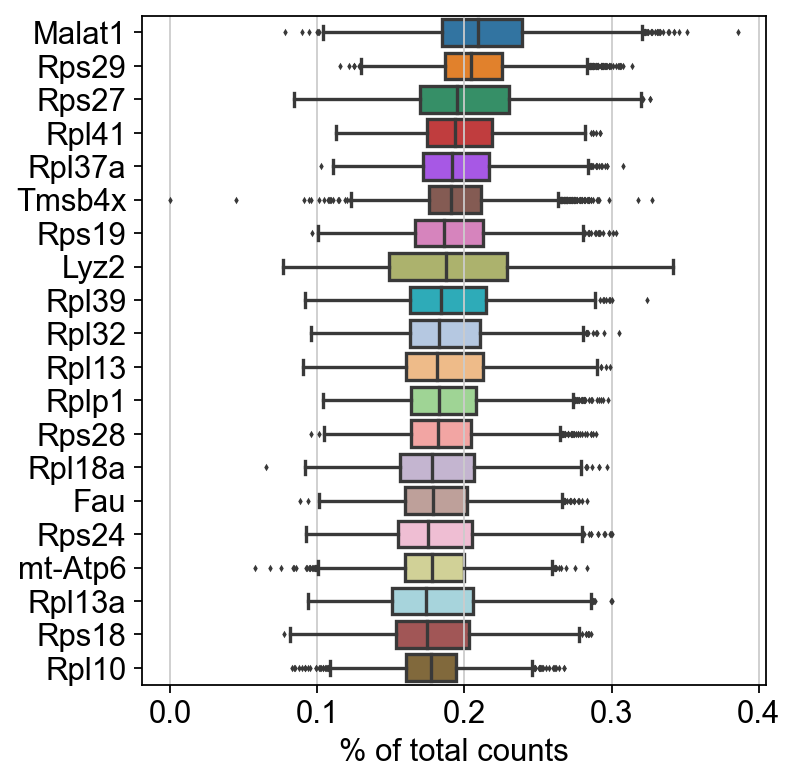

In [24]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Now our data are normalized

# 4. Identification of biologicaly variable genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


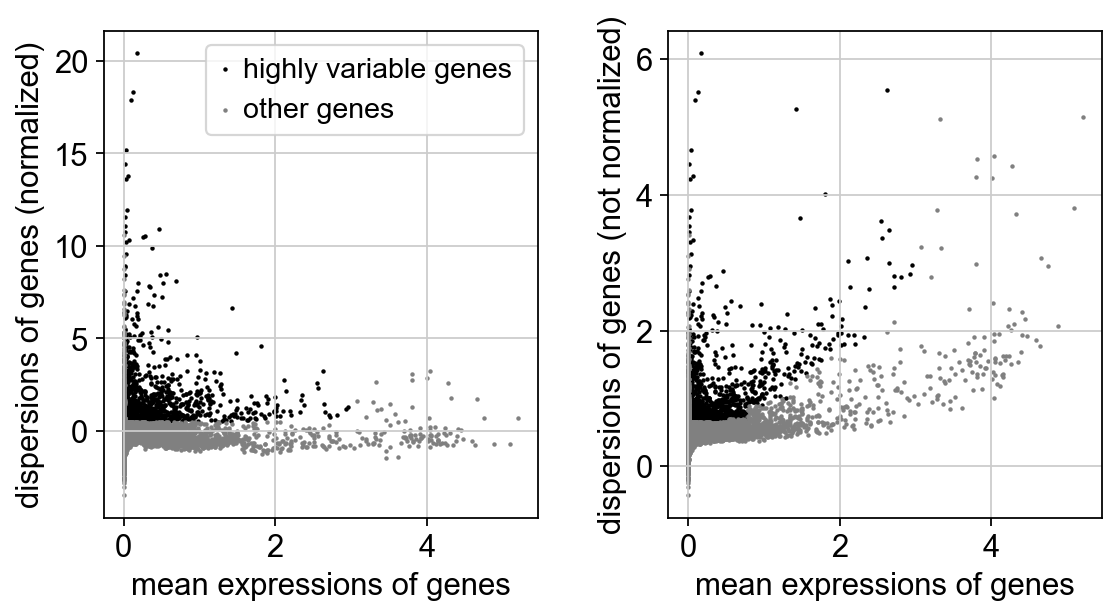

In [30]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

In [31]:
adata.var['highly_variable'].value_counts()

False    12387
True      1240
Name: highly_variable, dtype: int64

# 5. PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


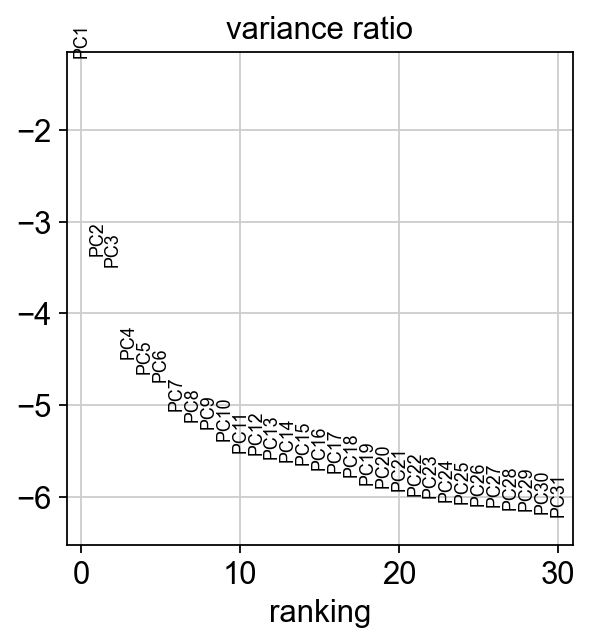

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

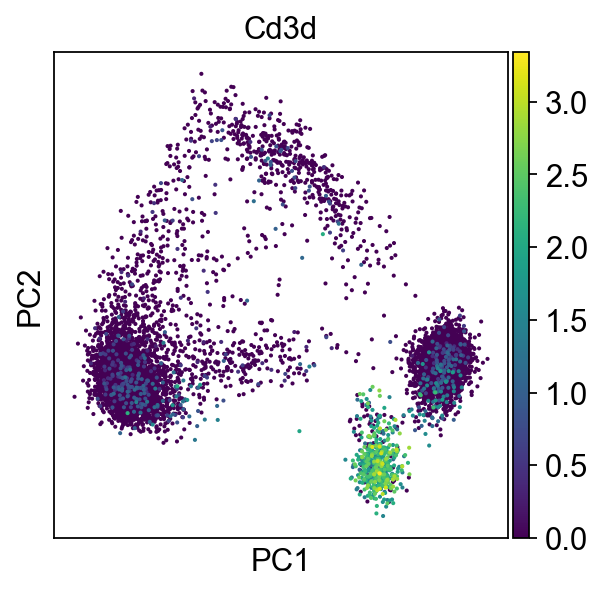

In [33]:
sc.pl.pca(adata, color='Cd3d')

### Cd3d is a T-cell surface marker and here we can see that it is expressed only in a particular cluster. We have to perform non-linear dimensionality reduction to obtain more informations.

# 6. Compute neghborhood graph and embedd it using UMAP visualization (non-linear dimensionality reduction)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


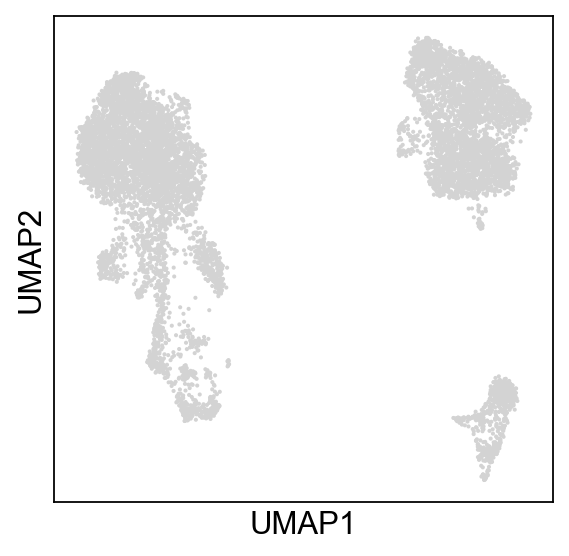

In [34]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# 7. Cells clustering

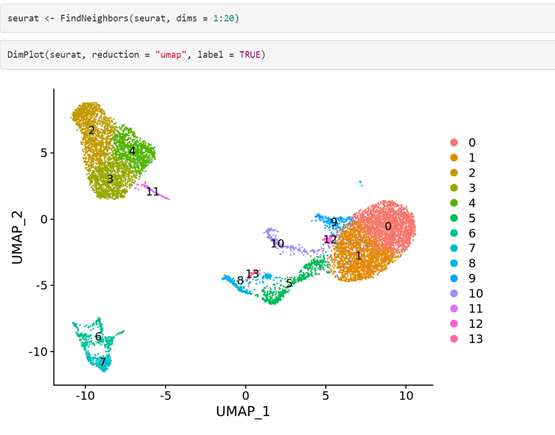

### Here is our clustering with Rstudio, we are going to have exact similar clustering, expet it's symetrically inversed but same number of cluster with the default resolution.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


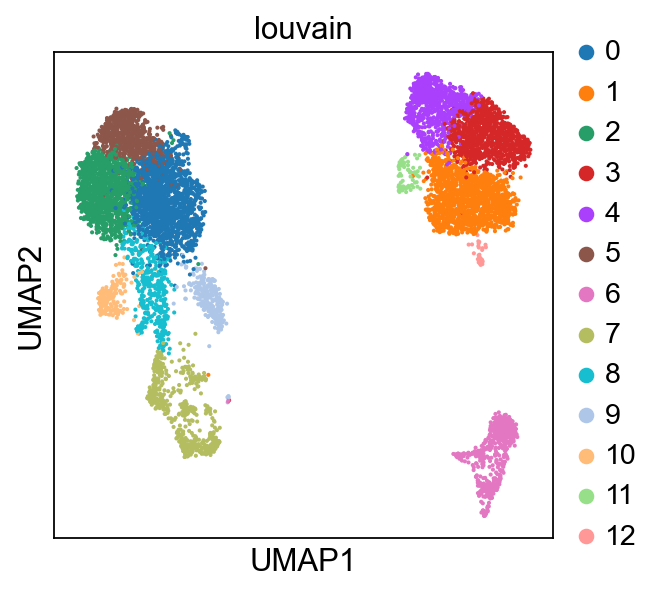

In [35]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color='louvain')

### Resolution is decrease to 1.0 in order to have 12 clusters, which is enough and consistent with the publication.

# 8. Visualizing gene expression in clusters

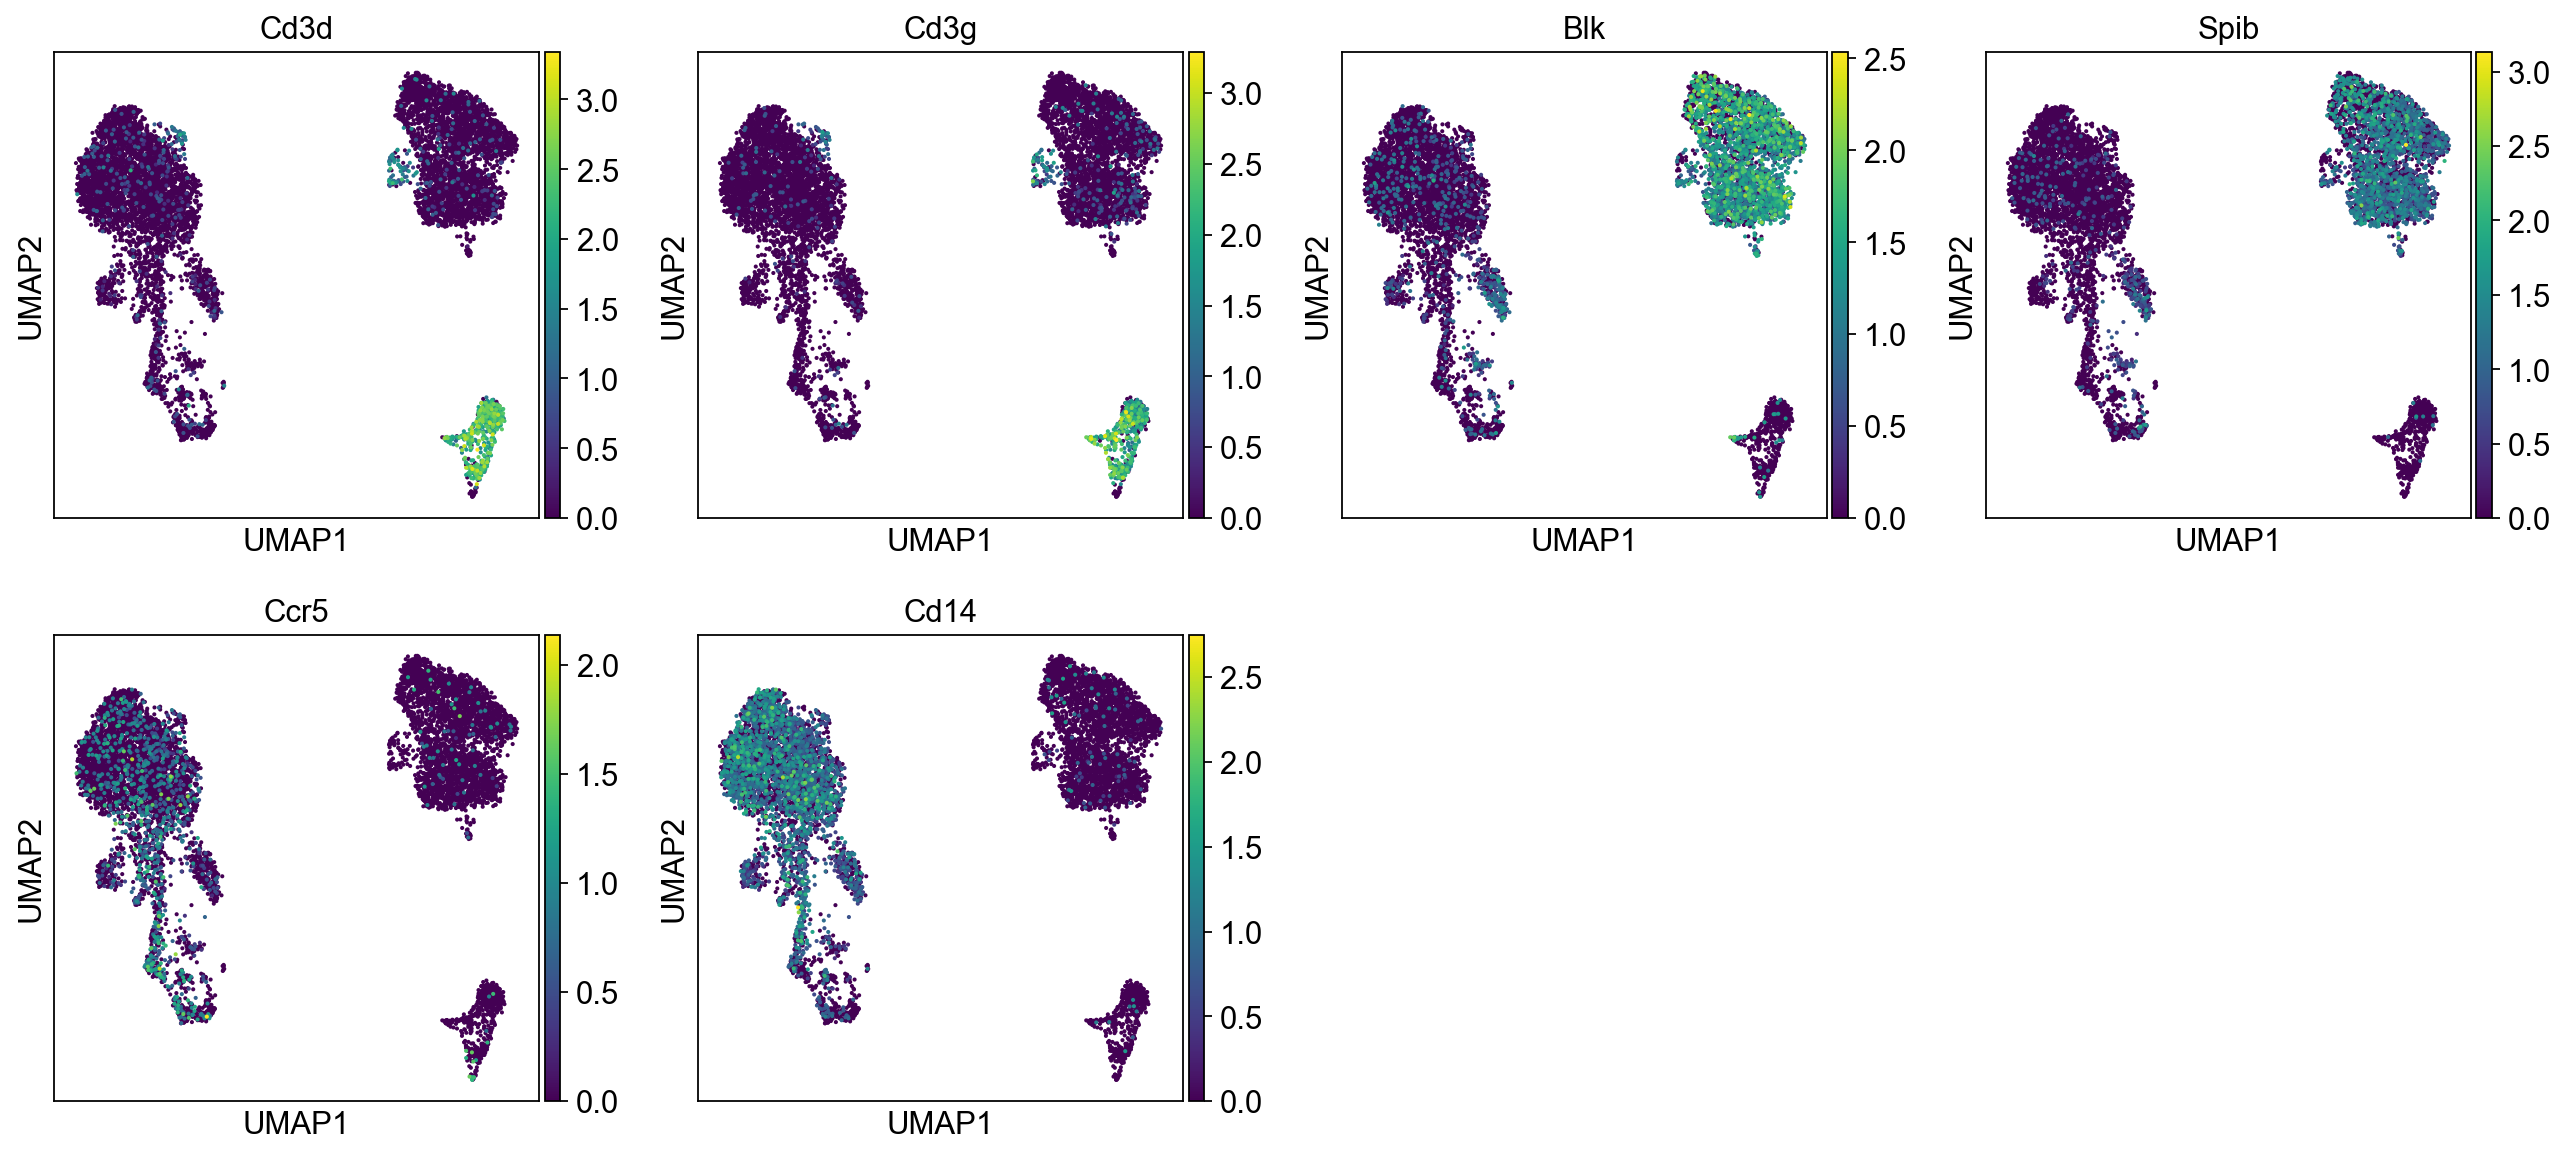

In [36]:
sc.pl.umap(adata, color=["Cd3d", "Cd3g", "Blk", "Spib", "Ccr5", "Cd14"])

### We can see that T cells markers Cd3d and Cd3g are located in the cluster 6.
### B cells markers Blk and Spib are located in the clusters 1, 2, 3 and 4 that can be considered as a super cluster here.
### Macrophages markers Ccr5 and Cd14 are in the clusters at the opposite side of the graph.

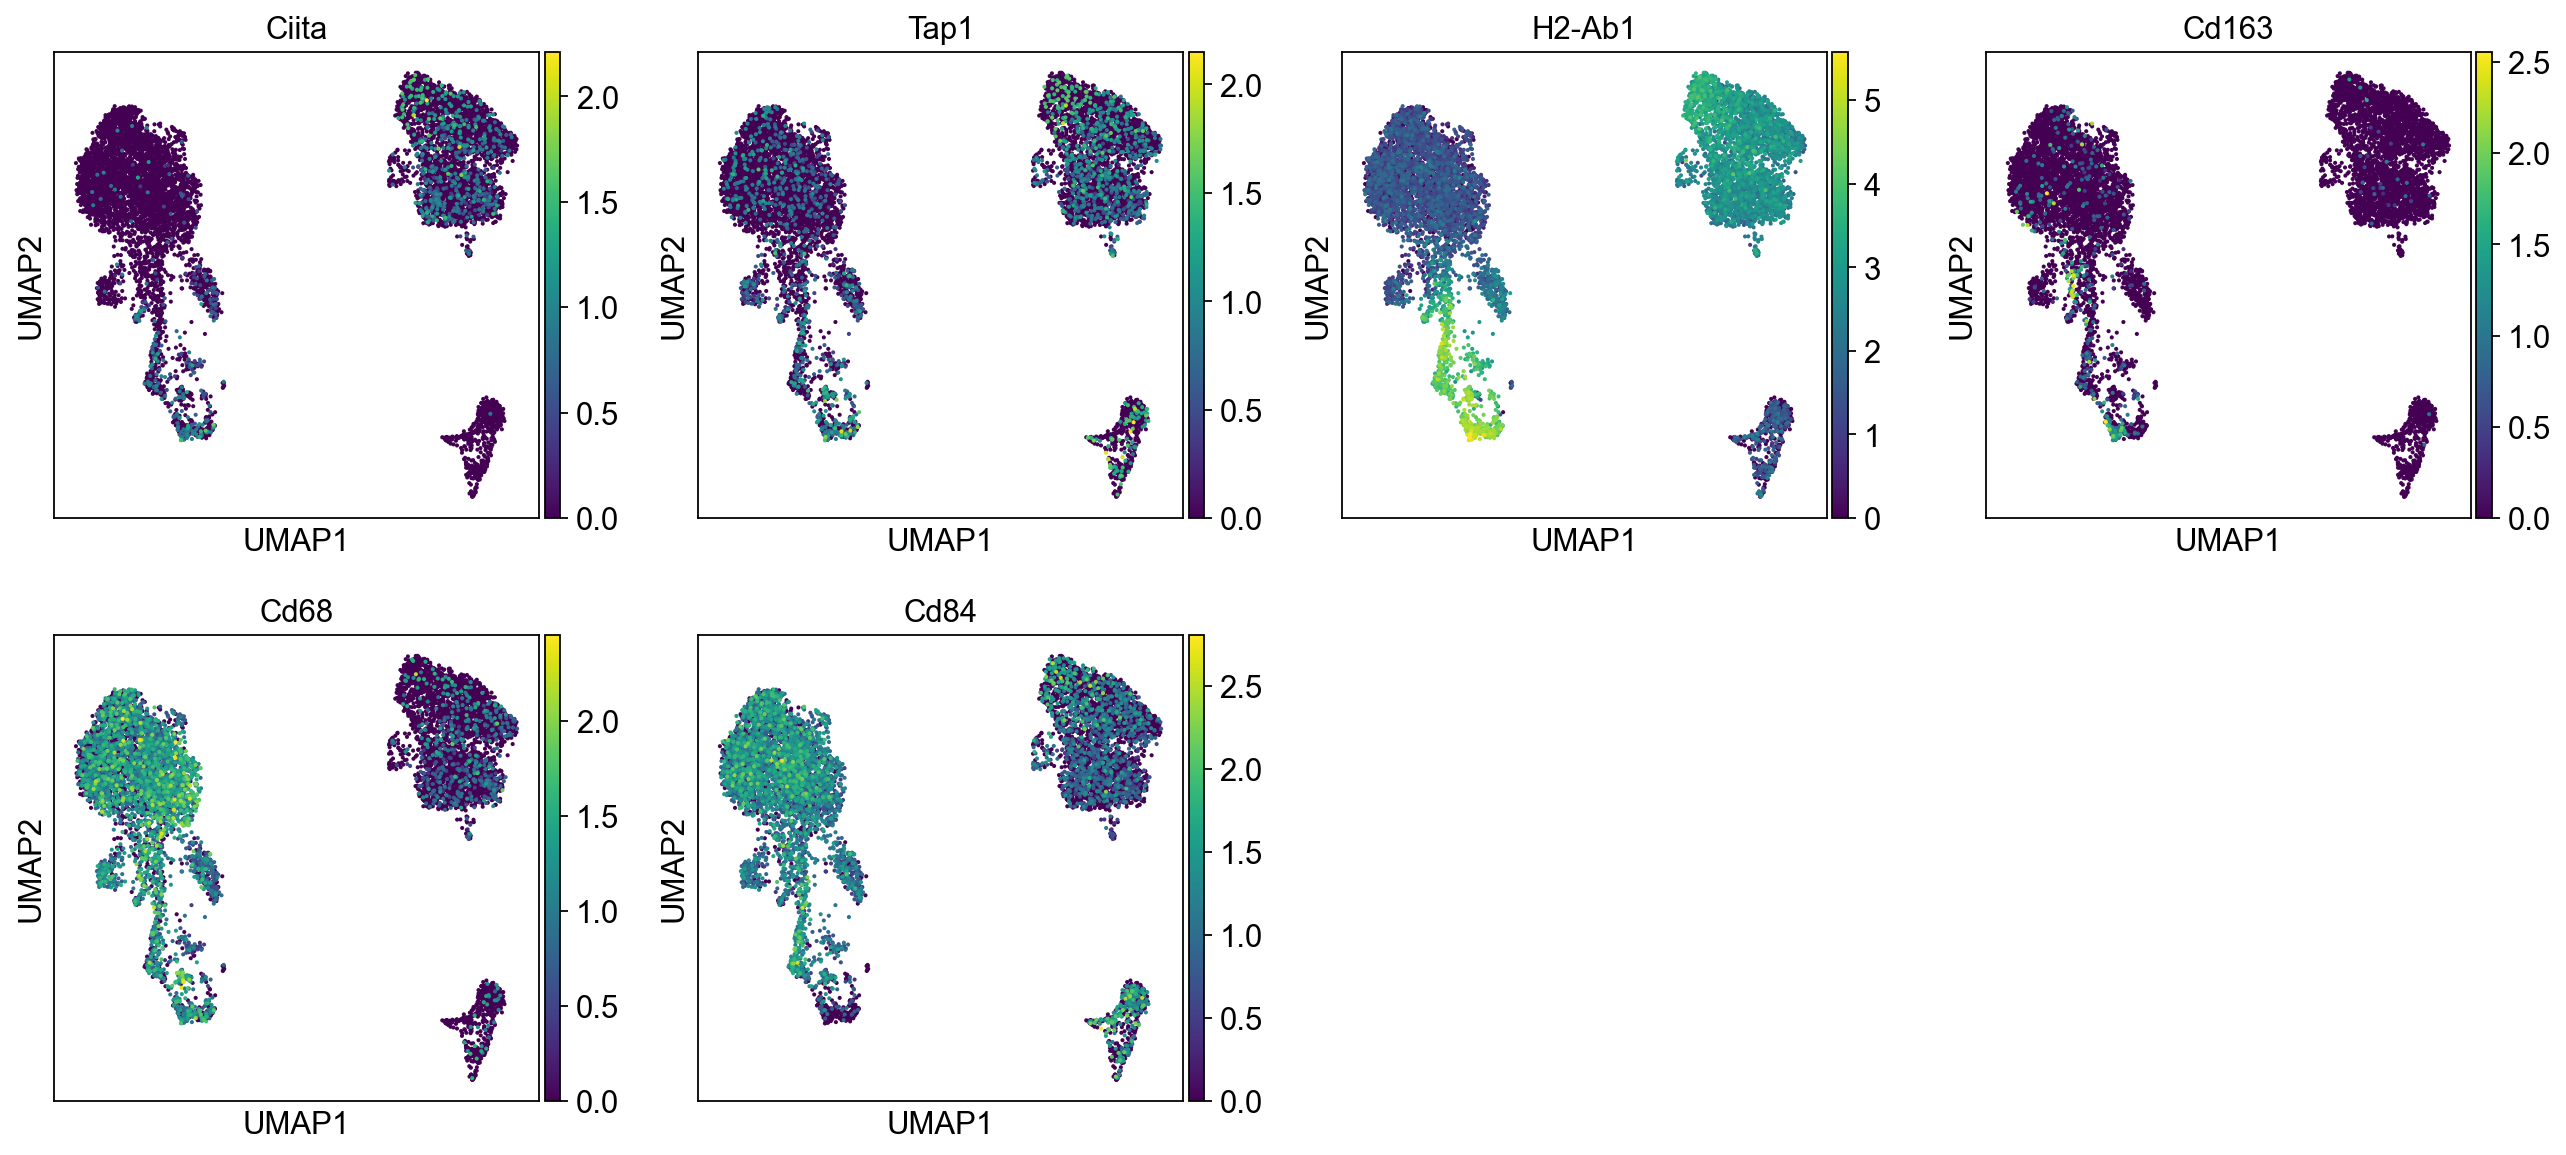

In [37]:
sc.pl.umap(adata, color=["Ciita", "Tap1", "H2-Ab1", "Cd163", "Cd68", "Cd84"])

### Tap1, Ciita and H2Ab1 are caracteristic markers of MHC class II. We can see that these markers are low expressed especially in macrophage's clusters (markers Cd163, Cd68 and Cd84) and also in T cells cluster. Naive T cells are not related to MHC class II. These observations seems to be a big point of the paper.

# 9. Running DGE tests to find cluster biomarkers

In [38]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


0     1     2      3     4      5       6       7     8      9     10  \
0  Cebpb  Xist  Apoe  Plac8  Ebf1  Apoc1  Tmsb10  H2-Ab1  Ccl6  Tgfb2  Hmgb2   

       11    12  
0  Ms4a4b  Ptma

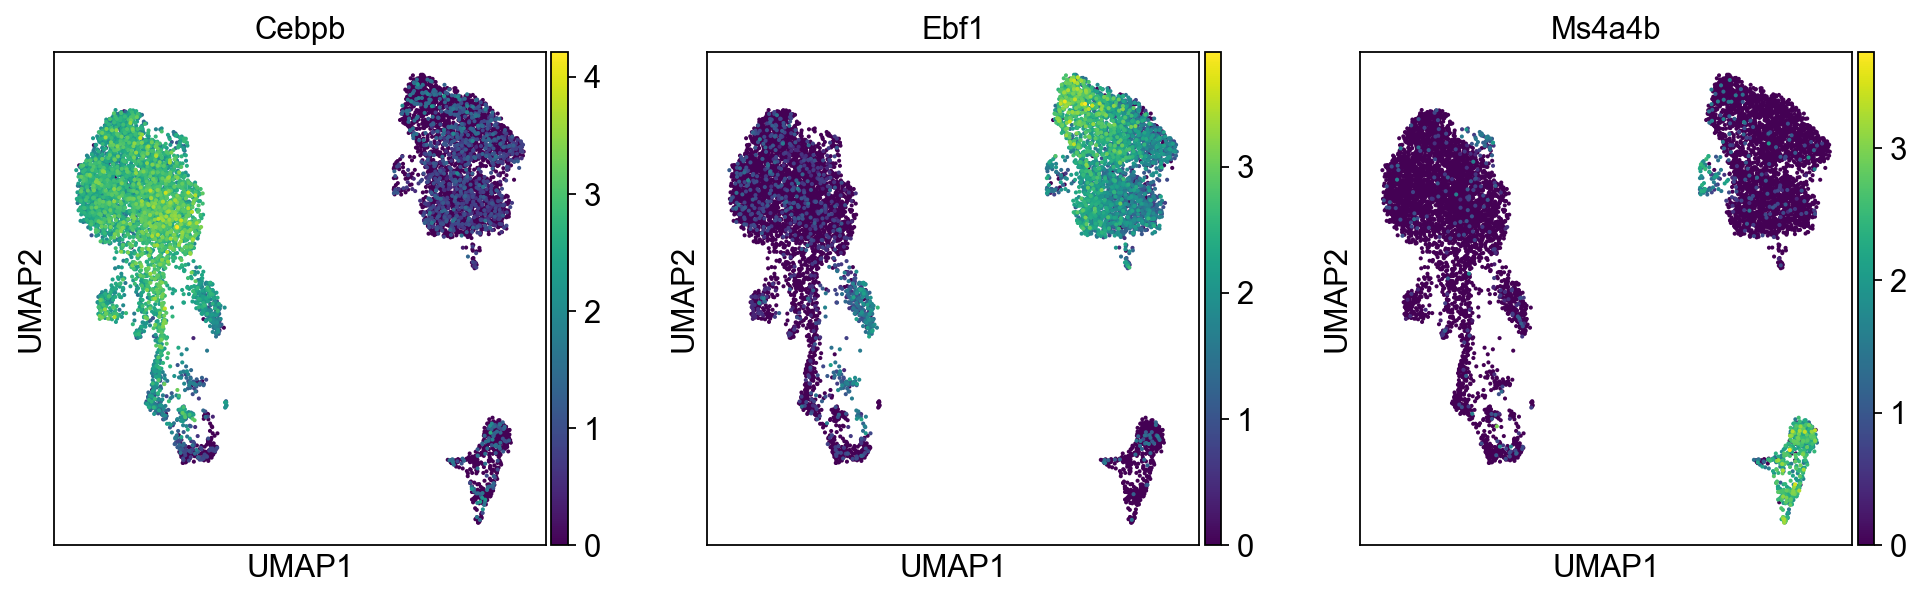

In [39]:
sc.pl.umap(adata, color=["Cebpb", "Ebf1", "Ms4a4b"])

### CEBPB is critical for normal macrophage functionning, it expression cluster is consistent with our previous result.

### EBF1 controls the expression of key proteins required for B cell differentiation, signal transduction and function, this supercluster is essentially composed of B cells.

### MS4A4B Is a GITR-associated membrane adapter, expressed by T Cells which are in cluster 6.

### With Rstudio we can change things with different argument and parameters but the conclusion about the genes expression are the same

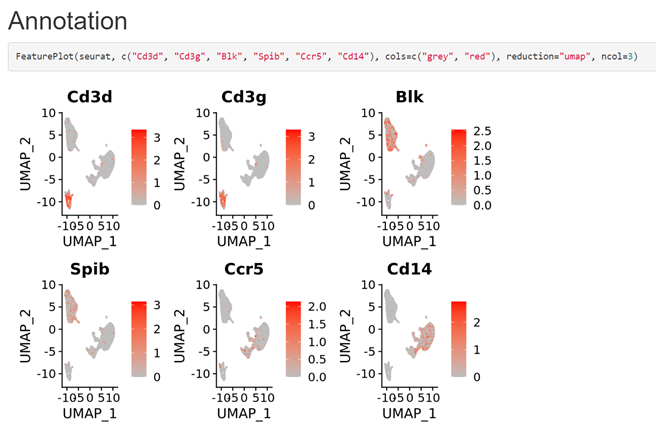

### Important figure of the publication which show the same result than our analysis about expression of T, B and macrophage markers :

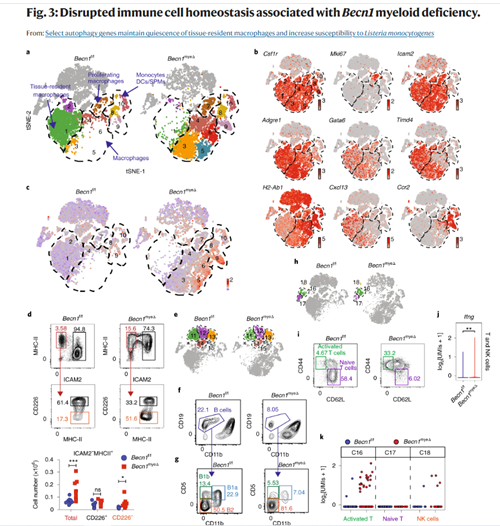

### Violin plot obtained with Rstudio, we can do that we scanpy also but we are going to show some other type of plot with it.

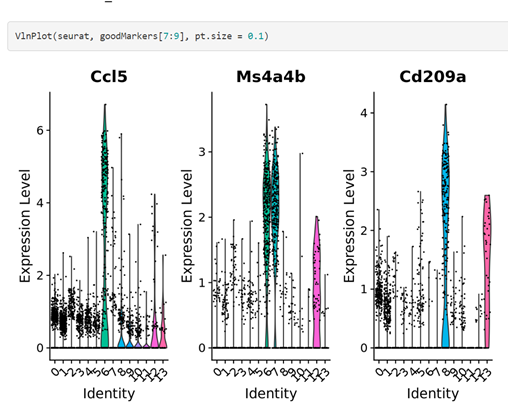

## Another clustering and change size

running Leiden clustering
    finished: found 13 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

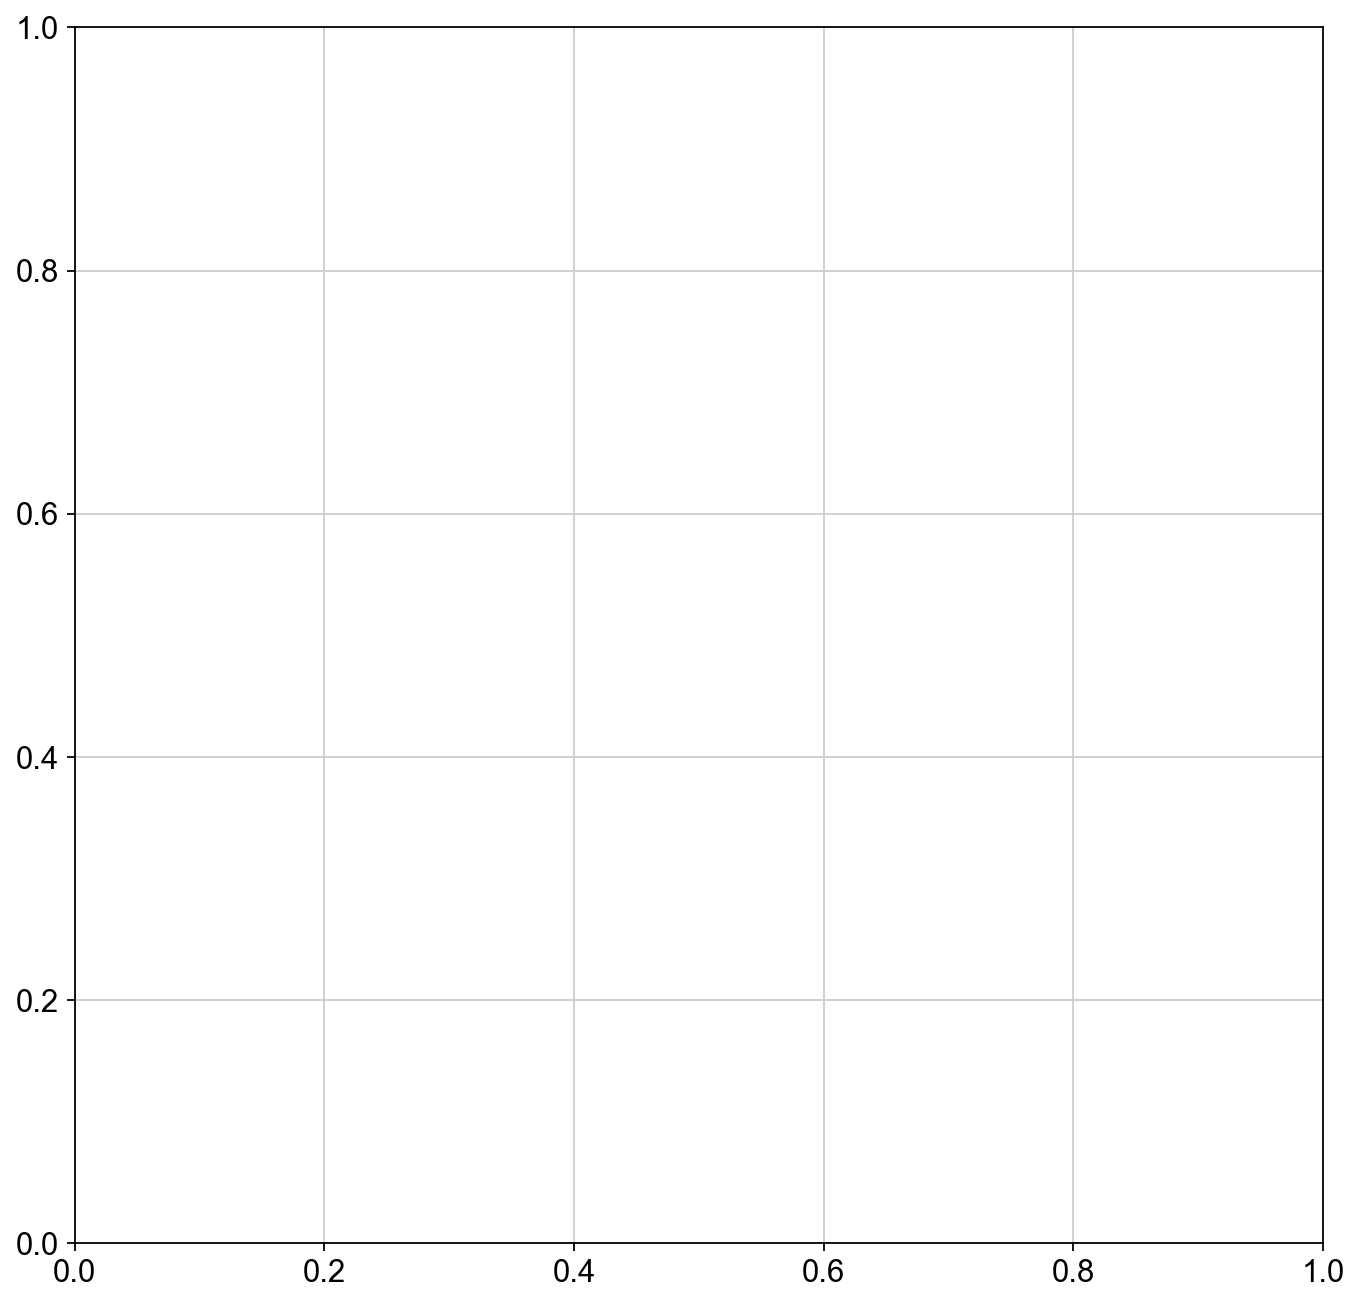

In [40]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, key_added='clusters', resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

## Extract embeddings

In [41]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [42]:
df = pd.DataFrame(adata.obsm['X_pca'])

In [43]:
df

0         1         2         3         4         5         6   \
0    -9.119764 -1.282535 -0.885184  0.274666  0.733903 -0.910187 -0.889686   
1     9.296515 -0.463599 -0.136218 -0.990328  1.370408 -0.223826 -1.083274   
2     5.440025 -4.525976  7.715979 -1.146151 -0.297346  1.043590 -2.855056   
3    -8.543623 -0.901590 -0.837291  1.680307  1.584285 -2.788996 -0.312586   
4    -8.076471  1.058893 -0.223489 -0.064590  1.520519  0.563309 -0.237894   
...        ...       ...       ...       ...       ...       ...       ...   
8795  9.188855 -0.134048 -2.690152  0.489191 -1.376200  1.306879  0.194542   
8796 -6.979815  1.290697 -1.375678  0.172244  2.909408  1.761149  0.814529   
8797  5.437526 -5.798440  9.038294  0.440424  0.467646  0.341137  0.244580   
8798 -6.906256 -1.179636 -0.063512  0.053325 -1.480986  0.001862 -0.642441   
8799 -7.031966 -1.083983 -0.357906 -0.231636  0.029538 -1.762841 -1.150683   

            7         8         9   ...        40        41        42  \
0    -0.255386  1.267533  0.673291  ... -0.658754  0.048785 -0.046942   
1     0.296893  0.299721 -0.170157  ... -1.073201  0.514334 -1.002823   
2     1.131071 -1.816329 -0.067117  ...  0.855952  0.391095  0.249836   
3    -1.725839 -1.928761  0.065957  ...  0.588123 -0.053633 -0.237592   
4    -0.540238 -0.550824 -0.319476  ...  0.962096 -0.377511 -0.167793   
...        ...       ...       ...  ...       ...       ...       ...   
8795 -0.298310  0.018731  1.401032  ...  0.259622 -0.401398  0.227628   
8796 -0.609278  2.920968 -0.362976  ...  0.434230 -0.381138 -0.406050   
8797  0.099298  0.235862 -1.035682  ...  0.558516  1.757823 -0.423811   
8798  0.877696  0.575808  1.091869  ...  0.348847  0.479591  0.112614   
8799  0.983182  0.245582 -0.956625  ...  0.740542 -0.642109  0.266403   

            43        44        45        46        47        48        49  
0    -0.734876 -0.690331  0.213620 -0.734309 -0.374478  0.470112  0.079225  
1    -1.661775  0.523274  0.563139  0.248037 -0.305617 -1.305873  0.373283  
2     0.744341  0.197175  0.563766  0.447465  0.320309 -0.894470  1.658269  
3    -0.250697  0.204604  0.718431 -0.631009  0.264155  0.485527  0.049450  
4     0.246997 -0.111821 -0.092415 -0.378919  0.552357 -0.071532  0.057979  
...        ...       ...       ...       ...       ...       ...       ...  
8795 -0.354983 -0.673145 -0.091845 -0.466074  0.307881 -0.092114  0.265853  
8796 -0.275899  0.038550  0.297283 -0.268579 -0.633394 -0.504228 -0.557350  
8797  0.587554  0.854589  0.519909  0.179640  1.604558 -1.063757  0.893515  
8798 -0.785777 -0.081068  0.865019 -1.286571 -1.127910 -1.204391 -2.142047  
8799  0.979288  0.128073  1.332746  0.333613  0.139047 -0.235444  1.263444  

[8800 rows x 50 columns]

In [44]:
adata.X

<8800x13627 sparse matrix of type '<class 'numpy.float32'>'
	with 17568582 stored elements in Compressed Sparse Row format>

In [45]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
Rp1             ENSMUSG00000025900      287  False                287   
Mrpl15          ENSMUSG00000033845     2587  False               2587   
Lypla1          ENSMUSG00000025903     2209  False               2209   
Tcea1           ENSMUSG00000033813     3817  False               3817   
Atp6v1h         ENSMUSG00000033793     1341  False               1341   
...                            ...      ...    ...                ...   
AC168977.2      ENSMUSG00000094915       41  False                 41   
AC168977.1      ENSMUSG00000079808      229  False                229   
PISD            ENSMUSG00000095041     5478  False               5478   
DHRSX           ENSMUSG00000063897     2085  False               2085   
CAAA01147332.1  ENSMUSG00000095742      133  False                133   

                mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
Rp1                0.033240           0.032700              96.912651   
Mrpl15             0.351441           0.301172              72.170826   
Lypla1             0.283563           0.249640              76.237091   
Tcea1              0.574763           0.454105              58.939329   
Atp6v1h            0.162651           0.150702              85.574441   
...                     ...                ...                    ...   
AC168977.2         0.004518           0.004508              99.558950   
AC168977.1         0.029260           0.028840              97.536575   
PISD               1.163404           0.771683              41.071429   
DHRSX              0.268287           0.237668              77.570998   
CAAA01147332.1     0.014522           0.014418              98.569277   

                total_counts  log1p_total_counts  highly_variable     means  \
Rp1                    309.0            5.736572            False  0.036598   
Mrpl15                3267.0            8.091933            False  0.365372   
Lypla1                2636.0            7.877397            False  0.305063   
Tcea1                 5343.0            8.583730            False  0.542383   
Atp6v1h               1512.0            7.321850            False  0.183925   
...                      ...                 ...              ...       ...   
AC168977.2              42.0            3.761200            False  0.005592   
AC168977.1             272.0            5.609472             True  0.033597   
PISD                 10815.0            9.288782             True  0.911861   
DHRSX                 2494.0            7.822044            False  0.279732   
CAAA01147332.1         135.0            4.912655            False  0.016891   

                dispersions  dispersions_norm  
Rp1                0.334311         -0.675878  
Mrpl15             0.517907         -0.143443  
Lypla1             0.515622         -0.154153  
Tcea1              0.466751         -0.580079  
Atp6v1h            0.506974         -0.042960  
...                     ...               ...  
AC168977.2         0.395885         -0.450169  
AC168977.1         0.668925          0.550691  
PISD               0.929544          0.617495  
DHRSX              0.427122         -0.568964  
CAAA01147332.1     0.276400         -0.888157  

[13627 rows x 13 columns]

In [46]:
adata.obs

n_genes  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGAAGGTGA-1     1826               1825                 7.509883   
AAACCTGAGATCGATA-1     1742               1741                 7.462789   
AAACCTGAGCTGCGAA-1      979                979                 6.887553   
AAACCTGAGTGTGGCA-1     2370               2370                 7.771067   
AAACCTGCAGGGTATG-1     2191               2190                 7.692113   
...                     ...                ...                      ...   
TTTGTCATCATTGCCC-1     2543               2542                 7.841100   
TTTGTCATCCATGAGT-1     3320               3317                 8.107117   
TTTGTCATCCCATTAT-1     1061               1060                 6.966967   
TTTGTCATCCCATTTA-1     1085               1085                 6.990257   
TTTGTCATCTTTAGGG-1     1689               1689                 7.432484   

                    total_counts  log1p_total_counts  total_counts_mt  \
AAACCTGAGAAGGTGA-1        6109.0            8.717682            243.0   
AAACCTGAGATCGATA-1        6796.0            8.824237            267.0   
AAACCTGAGCTGCGAA-1        3589.0            8.185907             90.0   
AAACCTGAGTGTGGCA-1       10196.0            9.229849            290.0   
AAACCTGCAGGGTATG-1        8396.0            9.035630            281.0   
...                          ...                 ...              ...   
TTTGTCATCATTGCCC-1       10464.0            9.255792            387.0   
TTTGTCATCCATGAGT-1       14962.0            9.613336            432.0   
TTTGTCATCCCATTAT-1        2682.0            7.894691             57.0   
TTTGTCATCCCATTTA-1        2658.0            7.885705            111.0   
TTTGTCATCTTTAGGG-1        6058.0            8.709300            160.0   

                    log1p_total_counts_mt  pct_counts_mt louvain clusters  
AAACCTGAGAAGGTGA-1               5.497168       3.977738       0        1  
AAACCTGAGATCGATA-1               5.590987       3.928782       3        3  
AAACCTGAGCTGCGAA-1               4.510859       2.507662       6        4  
AAACCTGAGTGTGGCA-1               5.673323       2.844253       0        1  
AAACCTGCAGGGTATG-1               5.641907       3.346832       0        1  
...                                   ...            ...     ...      ...  
TTTGTCATCATTGCCC-1               5.961005       3.698395       1        2  
TTTGTCATCCATGAGT-1               6.070738       2.887315       9        8  
TTTGTCATCCCATTAT-1               4.060443       2.125280       6        4  
TTTGTCATCCCATTTA-1               4.718499       4.176073       2        0  
TTTGTCATCTTTAGGG-1               5.081404       2.641136       0        1  

[8800 rows x 10 columns]

In [47]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'}), ('pca', {'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([73.81892   ,  8.53343   ,  7.5053015 ,  2.759925  ,  2.3524082 ,
        2.1441278 ,  1.5602802 ,  1.3916726 ,  1.2902629 ,  1.1255162 ,
        0.98494637,  0.9668094 ,  0.9219712 ,  0.8954728 ,  0.87051547,
        0.82555056,  0.7927603 ,  0.7623926 ,  0.69425786,  0.6768572 ,
        0.6532236 ,  0.6213247 ,  0.60657644,  0.5800195 ,  0.56420594,
        0.55470234,  0.548218  ,  0.53337073,  0.5240455 ,  0.5094509 ,
        0.49334124,  0.4837355 ,  0.4753043 ,  0.47199595,  0.46476614,
        0.45250225,  0.44985813,  0.44778296,  0.44411868,  0.4364651 ,
        0.43463224,  0.42930624,  0.42807636,  0.42261302,  0.41779962,
        0.41352874,  0.4112044 ,  0.40868562,  0.40535724,  0.3995873 ],
      dtype=float32), 'variance_ratio': array([0.29950637, 0.03462278, 0.03045135, 0.01119788, 0.0

### We are going to show 2 more way to visualize our expression data within scanpy. First we can use a dotplot. This type of plot summarizes two types of information: the color represents the mean expression within each of the categories (in this case in each cluster) and the dot size indicates the fraction of cells in the categories expressing a gene.

In [48]:
marker_genes_dict = {
    'Macrophage': ['Cebpb', 'Cd14'],
    'T-cell': ['Cd3d', 'Ms4a4b'],
    'B-cell': ['Ebf1', 'Spib'],
}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: Macrophage, T-cell, B-cell


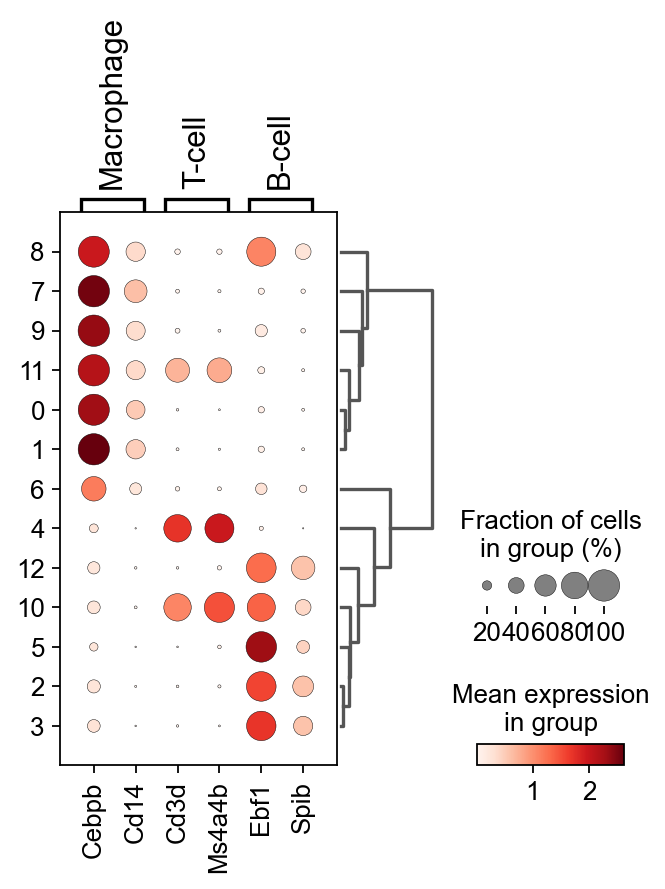

In [49]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

In [50]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '7': 'Macrophage',
     '2': 'B-cell',
     '4': 'T-cell',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell type']`


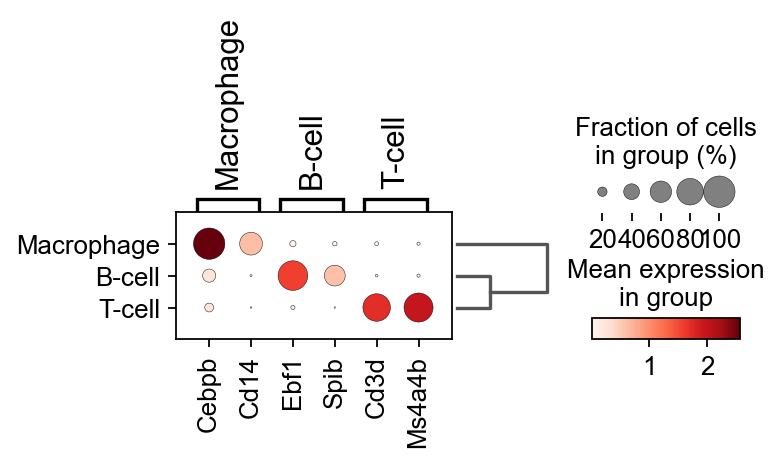

In [51]:
sc.pl.dotplot(adata, marker_genes_dict, 'cell type', dendrogram=True)

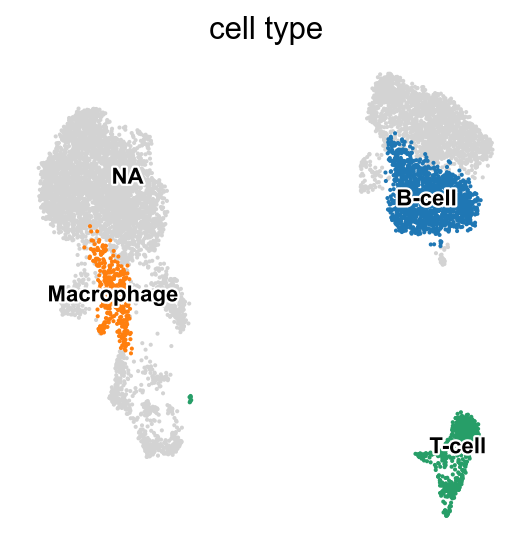

In [52]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

### A good way to vizualize expression data is to do a heatmap

categories: 0, 1, 2, etc.
var_group_labels: Macrophage, T-cell, B-cell


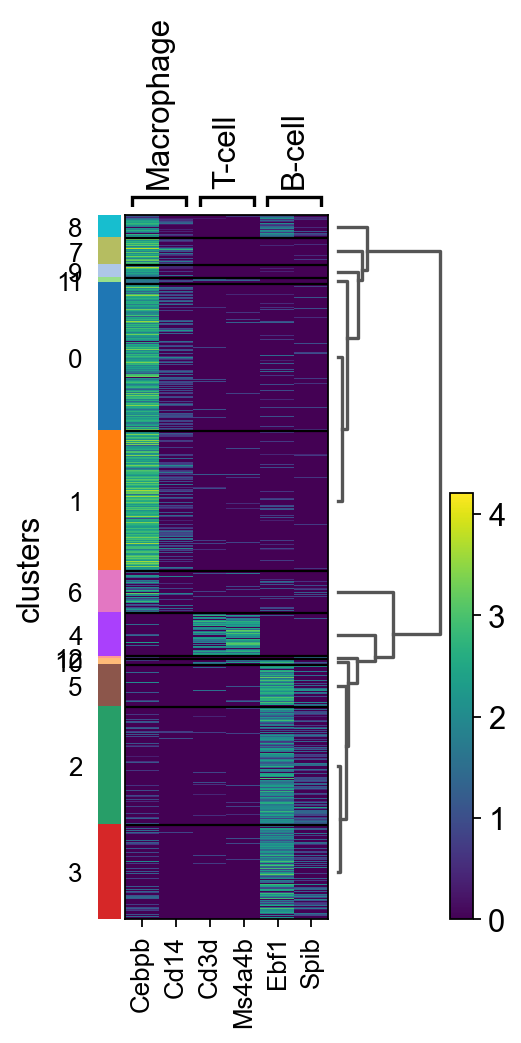

In [53]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)

### This various visual reprensation seems to confirm our observations and the paper results, espcially about T naive cells indepedent and MHC class 2 are low expressed macrophages clusters. To confirm that and build more robust plot we can add other markers and make conclusions about their differential expressions.

# Trajectory inference

In [54]:
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [55]:
adata.X = adata.X.astype('float64')

In [56]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:01)


In [57]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [58]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:41)


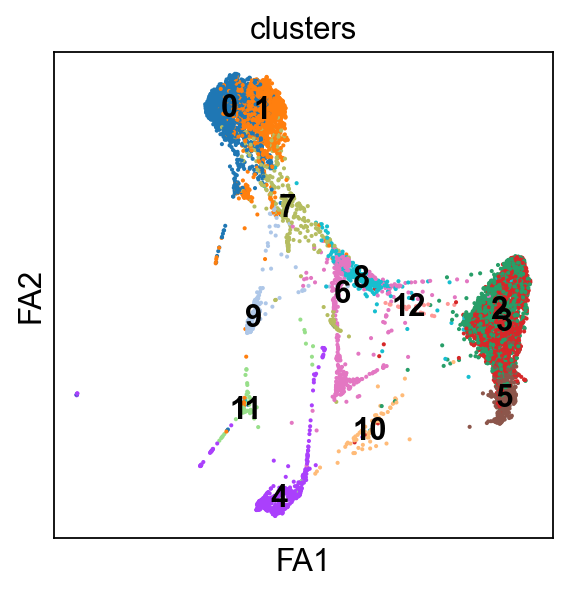

In [59]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

## Denoising 

In [60]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.99958074 0.99905497 0.99766344 0.9973277
     0.996796   0.99583083 0.99502856 0.99472135 0.9934916  0.99323016
     0.9925357  0.9913082  0.99024546]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [61]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:02:35)


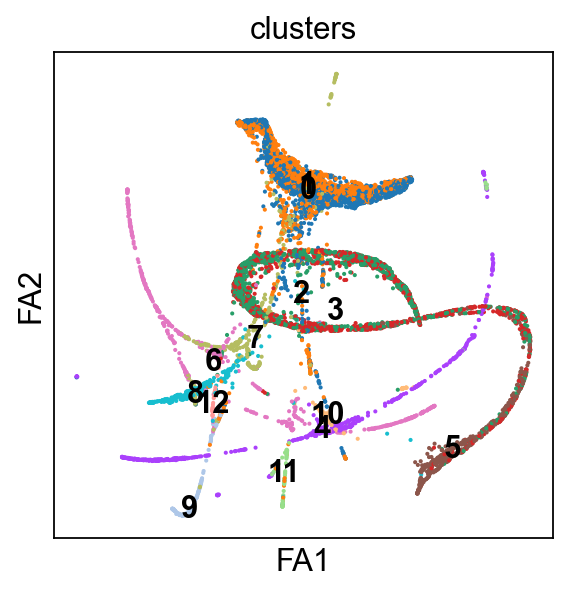

In [62]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [63]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 41 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [64]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


ValueError: Expected `colors` to be of length `41`, found `13`.

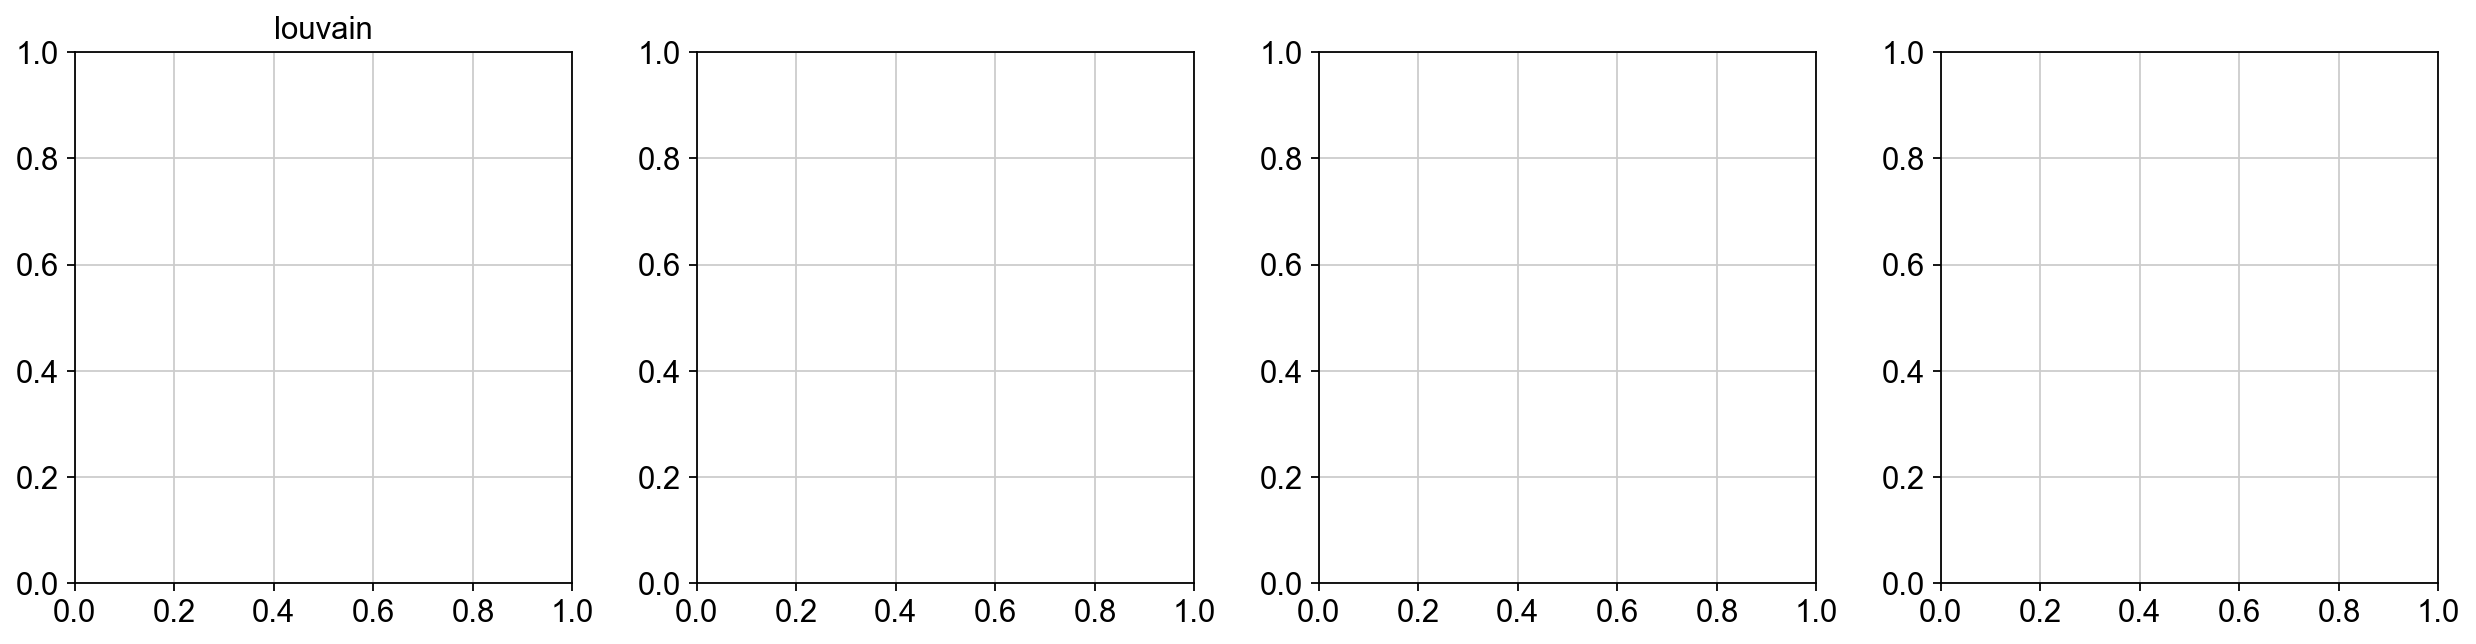

In [65]:
sc.pl.paga(adata, color=['louvain', 'Cebpb', 'Cd3d', 'Ebf1'])

ValueError: Expected `colors` to be of length `41`, found `13`.

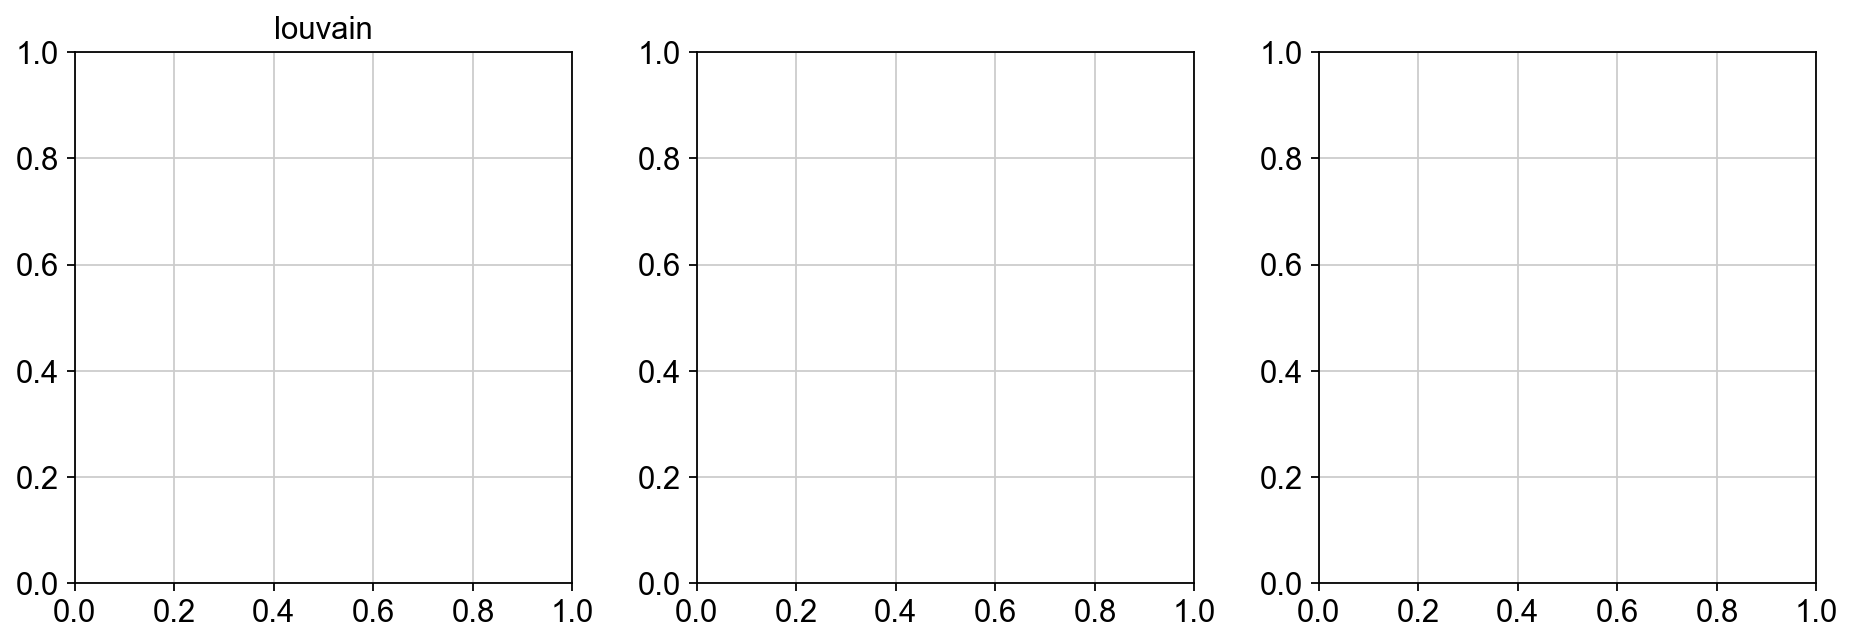

In [66]:
sc.pl.paga(adata, color=['louvain', 'Ms4a4b', 'Spib'])

In [67]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40'],
      dtype='object')

In [68]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [69]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40']

### Let’s use the annotated clusters for PAGA.

In [70]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


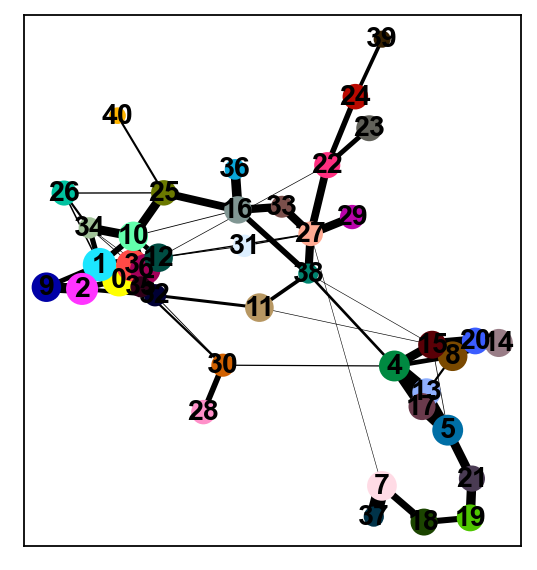

In [71]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

In [72]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'


KeyboardInterrupt: 

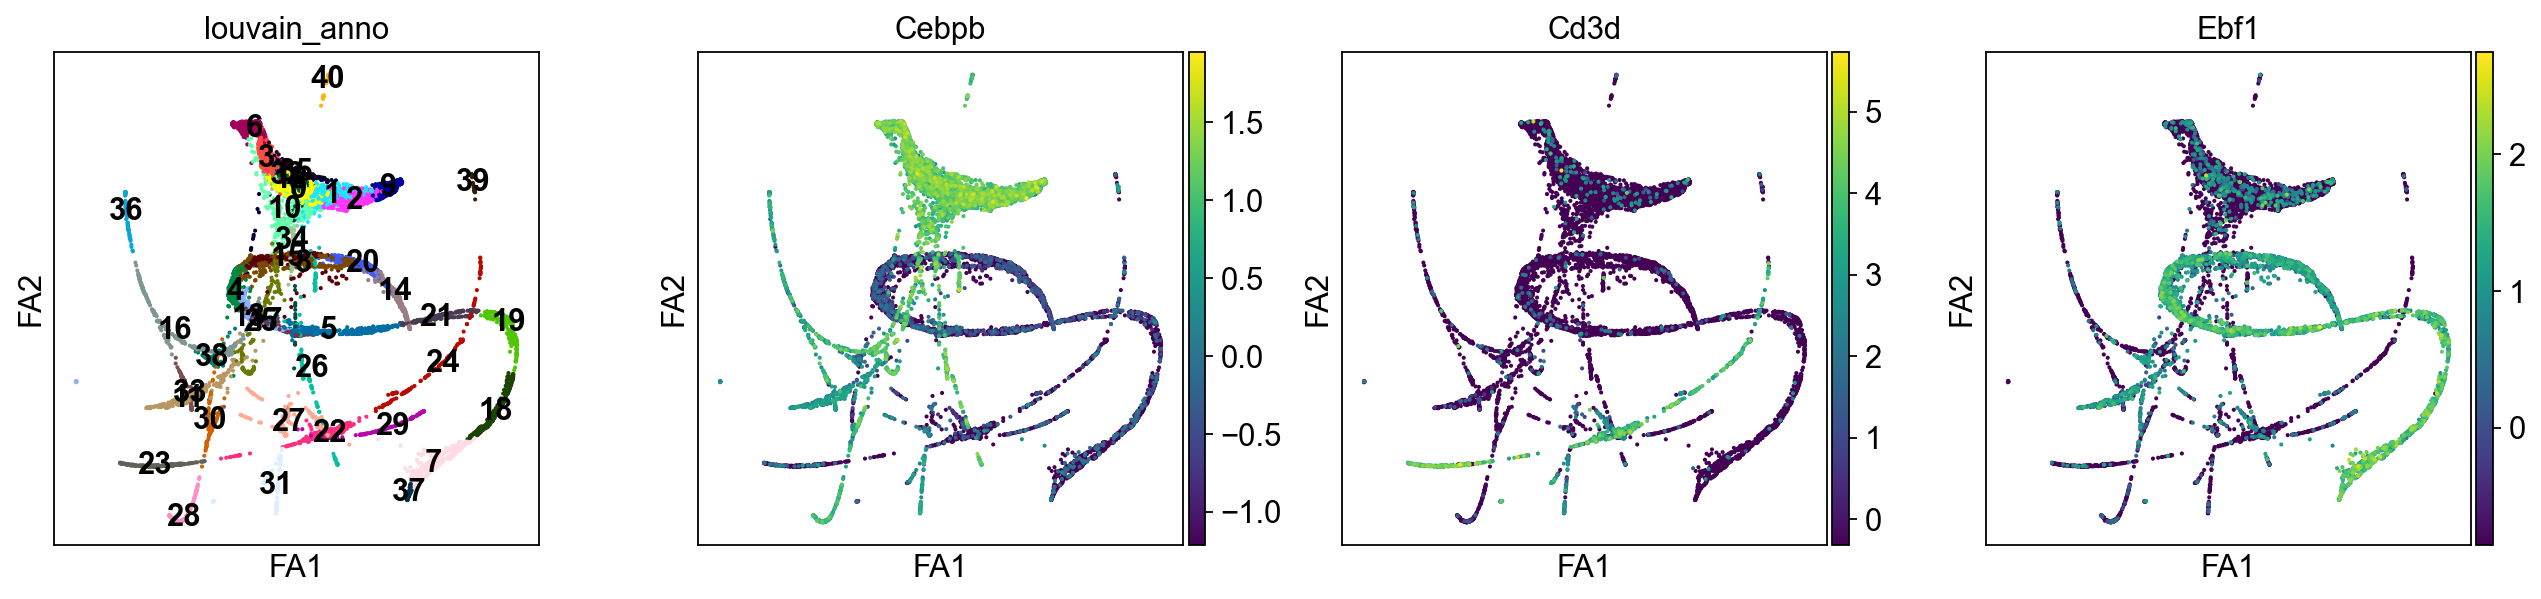

In [73]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Cebpb', 'Cd3d', 'Ebf1'], legend_loc='on data')

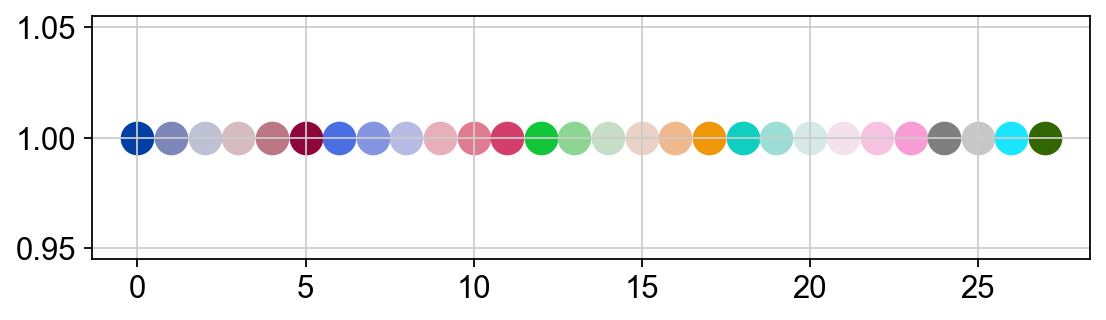

In [74]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [75]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [76]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [77]:
adata.uns['louvain_anno_colors'] = new_colors

--> added 'pos', the PAGA positions (adata.uns['paga'])


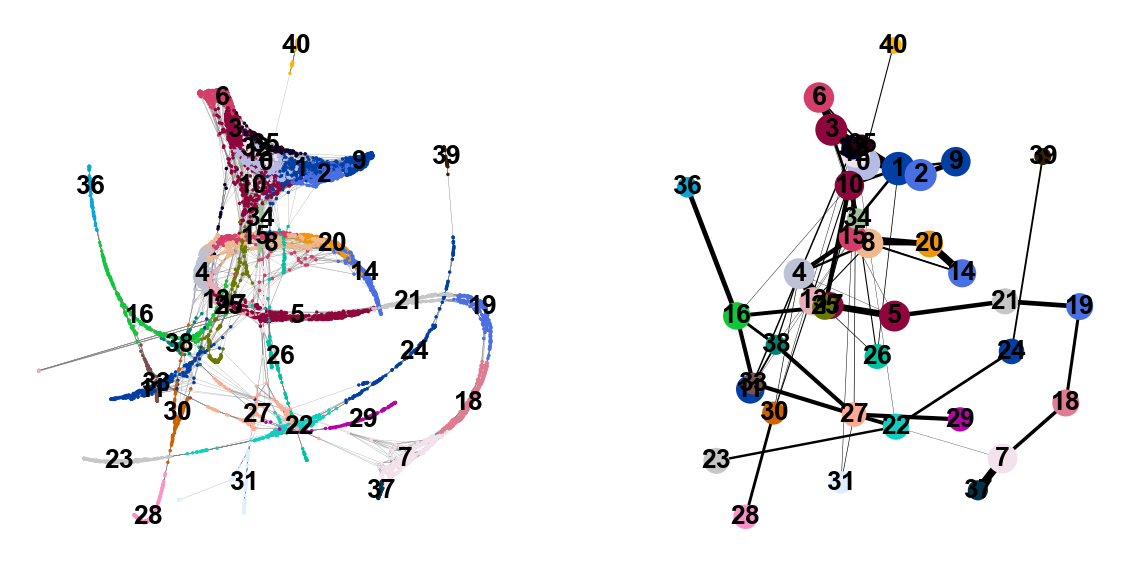

In [78]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [79]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '0')[0]

In [80]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [81]:
gene_names = ['Cebpb', 'Cd14',
              'Cd3d', 'Ms4a4b',
              'Ebf1', 'Spib']

In [82]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `._uns` of view, copying.


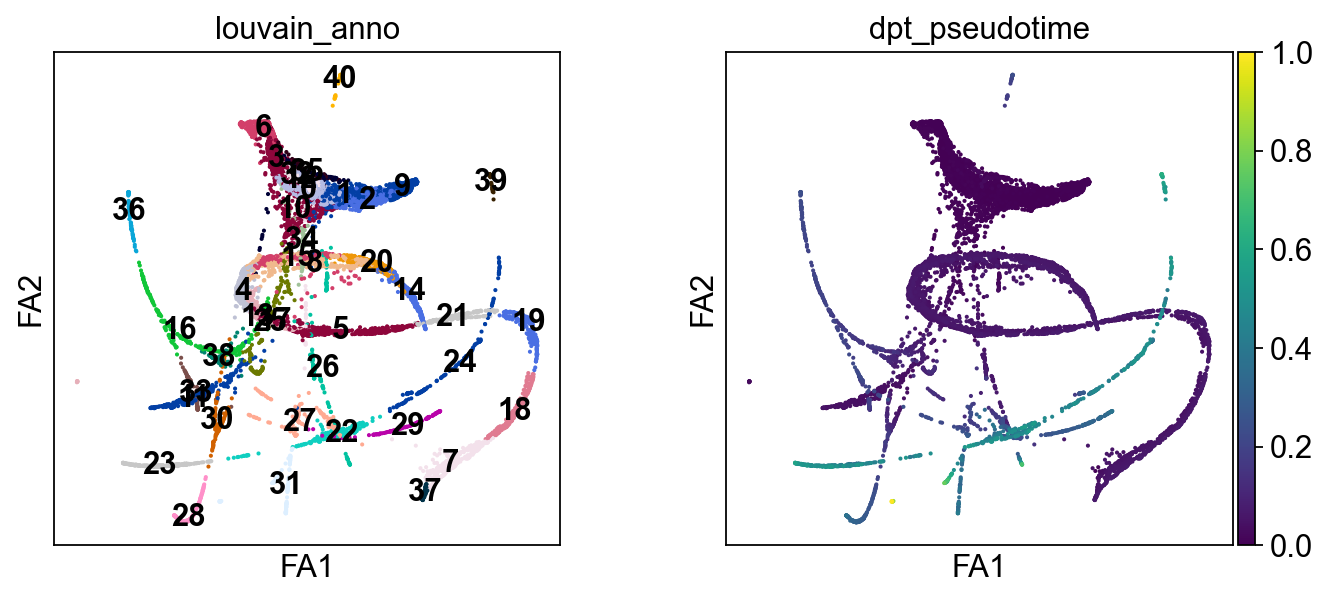

In [83]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [84]:
paths = [('macrophages', [12, 32, 34, 25]),
         ('T-cells', [22, 23, 24, 30]),
         ('B-cells', [26, 9, 25, 12, 9])]

In [85]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [86]:
adata.obs['clusters'] = adata.obs['louvain_anno']

In [87]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [ ]:
!mkdir write

In [ ]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/res.pdf')
pl.show()

### We can see that this is just another way to cluster and visiualize our gene expression data